In [1]:
import os
import csv
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pylab as py
import scipy
import statsmodels.formula.api as smf
import statsmodels.graphics as sg
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# data load - user
df = pd.read_csv('rating_with_user_metadata.csv')


data process

In [3]:
# Regroup the occupation to 4 levels
# 0 for Other, 1 for while collar , 2 for blue collar, 3 for academic 
conditions = [
    (df['Occupation'] == 0 ) | (df['Occupation'] == 13) | (df['Occupation'] == 16) | (df['Occupation'] == 19),  #0 
    (df['Occupation'] == 8 ) | (df['Occupation'] == 9) | (df['Occupation'] == 17) | (df['Occupation'] == 18), #2
    (df['Occupation'] == 1 ) | (df['Occupation'] == 4) | (df['Occupation'] == 10) | (df['Occupation'] == 15) #3
]
choices = [0,2,3] # 0 for Other, 1 for while collar , 2 for blue collar, 3 for academic 
df['new_occupation'] = np.select(conditions, choices, default='1')


In [4]:
# Regroup Age to 6 levels
df['new_age']=np.where(df['Age'] <18,'0-18',
                      np.where( np.logical_and(df['Age'] >=18, df['Age'] <25) ,'18-24',
                               np.where( np.logical_and(df['Age'] >=25, df['Age'] <35) ,'25-34',
                                       np.where( np.logical_and(df['Age'] >=35, df['Age'] <45) ,'35-44',
                                                np.where( np.logical_and(df['Age'] >=45, df['Age'] <55) ,'45-54',
                                                         '55+')
                                       )
                              )
                      )
                      )
df.groupby('new_age').count()[['userId']]



,userId
new_age,
0-18,28002
18-24,106787
25-34,221885
35-44,113660
45-54,91035
55+,36455


In [6]:
# convert to label
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Gender']=le.fit_transform(df['Gender'])
df['new_occupation']= le.fit_transform(df['new_occupation'])
df['new_age']= le.fit_transform(df['new_age'])
# df['new_rating']=le.fit_transform(df['rating'])
# df['new_rating']=le.inverse_transform(df['new_rating'])
df['new_rating']= df['rating'].astype(str)


In [ ]:
df[['new_occupation','Gender','new_rating','new_age']]


Text(0.5, 1.0, 'Occupation')

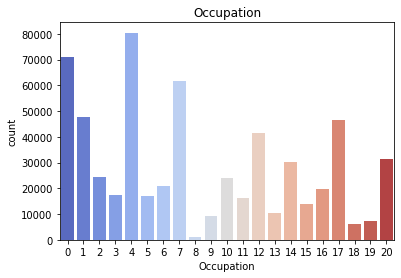

In [8]:
# plot of distribution of occupation 
sns.countplot(x='Occupation',data=df,palette='coolwarm').set_title('Occupation')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Regrouped Occupation')

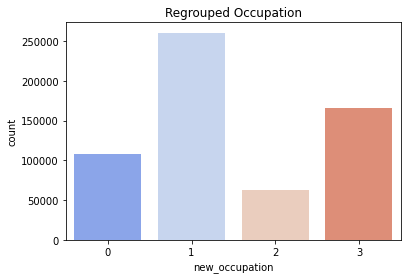

In [9]:
# plot of distribution of regrouped occupation 
# 0 for Other, 1 for while collar , 2 for blue collar, 3 for academic 
sns.countplot(df['new_occupation'],palette='coolwarm').set_title('Regrouped Occupation')


Mulitnominal Logistic Regression


We are tring to run a model of multinominal logistic regression to try to predict the raing simply based on Gender, Occupation, Age group.


In [12]:
#sklearn MlogR

Xtrain0 = df[['Gender','new_occupation','new_age']]
ytrain0 = df['new_rating']

# lr = LogisticRegression(solver='liblinear')
lr = LogisticRegression(multi_class='multinomial',max_iter=200)
lr.fit(Xtrain0, ytrain0)
preds = lr.predict(Xtrain0)

In [ ]:
#Create confusion matrix
confmtrx = np.array(confusion_matrix(ytrain0,preds))
#rows for true rating, columns for predicted rating 
pd.DataFrame(confmtrx, index=[np.arange(0.5,5.5,0.5)], columns=[np.arange(0.5,5.5,0.5)])

,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0.5,0,0,0,0,0,0,0,7281,0,0
1.0,0,0,0,0,0,0,0,17671,0,0
1.5,0,0,0,0,0,0,0,8092,0,0
2.0,0,0,0,0,0,0,0,39823,0,0
2.5,0,0,0,0,0,0,0,29719,0,0
3.0,0,0,0,0,0,0,0,122700,0,0
3.5,0,0,0,0,0,0,0,74522,0,0
4.0,0,0,0,0,0,0,0,160631,0,0
4.5,0,0,0,0,0,0,0,50790,0,0
5.0,0,0,0,0,0,0,0,86595,0,0


In [14]:
from sklearn.metrics import accuracy_score
1-accuracy_score(preds,ytrain0)#calculate error rate


0.7313072074724334

From the output, the error rate very high (73%) that we can conclued that the model of multinominal logistic model is not useful.
We cannot simply predict rating only by Gender, Occupation, Age group.